In [1]:
import torch
import numpy as np
from torch_geometric.loader import DataLoader

%reload_ext autoreload
%autoreload 2


## Test

In [2]:
import scipy.io
import os

file_name = 'cf_data_1000_6_30'
mat_data = scipy.io.loadmat('Data/' + file_name + '.mat')
beta_all = mat_data['betas']
phi_all = mat_data['Phii_cf'].transpose(0,2,1)
min_rate = mat_data['R_cf_opt_min'].T

# Parameters


In [3]:
_, _, num_sam, num_UE, num_AP = file_name.split('_')
num_sam = int(num_sam)
num_UE = int(num_UE)
num_AP  = int(num_AP) 

In [4]:

# num_UE = 5 # number of terminals
# num_AP = 30 # number of access points
num_antenna = 1
tau=20; power_f=0.2; D=1; f=1900; Hb=15; Hm=1.65; d0=0.01;d1=0.05;

# random_matrix = np.random.randn(tau, tau)
# U, S, V = np.linalg.svd(random_matrix)

# Hb = 15 # Base station height in m
# Hm = 1.65 # Mobile height in m
# f = 1900 # Frequency in MHz
# aL = (1.1 * np.log10(f) - 0.7) * Hm - (1.56 * np.log10(f) - 0.8)
# L = 46.3+33.9*np.log10(f)-13.82*np.log10(Hb)-aL

power_f=0.2 # downlink power
rho_p, rho_d = power_f, power_f

# Pd = power_f / 10 ** ((-203.975 + 10 * np.log10(20 * 10 ** 6) + 9) / 10) # normalized receive SNR
Ther_noise = 20000000 * 10**(-17.4) * 10**-3
Pd = 1/Ther_noise
Pu=Pd

d0=0.01 # km
d1=0.05 # km




In [5]:
num_train = 300
num_test = 200
batchSize = 32

lr = 5e-4
step_size = 5
gamma = 0.85

# FL
num_rounds = 200

num_client = num_AP 
num_epochs = 1
eval_round = num_rounds//10 if num_rounds//10 else 1

# Create data loader for training and testing 

In [6]:
from Utils.data_gen import Generate_Input, create_graph

# Beta_all, Phi_all = Generate_Input(num_train, tau, num_UE, num_AP, Pd, D=1, Hb=15, Hm=1.65, f=1900,
#                     var_noise=1, Pmin=0, seed=2017, d0=d0, d1=d1)
Beta_all, Phi_all = beta_all[:num_train], phi_all[:num_train]
train_data = create_graph(Beta_all, Phi_all, 'het')
train_loader = [
    DataLoader(train_data[i], batch_size=batchSize, shuffle=True)
    for i in range(num_AP)
]


# Beta_test, Phi_test = Generate_Input(num_test, tau, num_UE, num_AP, Pd, D=1, Hb=15, Hm=1.65, f=1900,
#                     var_noise=1, Pmin=0, seed=2017, d0=d0, d1=d1)
Beta_test, Phi_test = beta_all[-num_test:], phi_all[-num_test:]
test_data = create_graph(Beta_test, Phi_test, 'het')
test_loader = [
    DataLoader(test_data[i], batch_size=batchSize, shuffle=False)
    for i in range(num_AP)
]


train_data_cen = create_graph(Beta_all, Phi_all, 'het', isDecentralized=False)
train_loader_cen = DataLoader(train_data_cen, batch_size=batchSize, shuffle=True)
test_data_cen = create_graph(Beta_test, Phi_test, 'het', isDecentralized=False)
test_loader_cen = DataLoader(test_data_cen, batch_size=batchSize, shuffle=False)

In [7]:
hidden_channels = 64 # > 4
num_gnn_layers = 2


ap_dim = train_data[0][0]['AP'].x.shape[1]
ue_dim = train_data[0][0]['UE'].x.shape[1]
edge_dim = train_data[0][0]['down'].edge_attr.shape[1]
tt_meta = [('UE', 'up', 'AP'), ('AP', 'down', 'UE')]
dim_dict = {
    'UE': ue_dim,
    'AP': ap_dim,
    'edge': edge_dim,
}
dim_dict

{'UE': 20, 'AP': 1, 'edge': 1}

In [12]:

from Models.GNN import APHetNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

global_model = APHetNet(
    metadata=tt_meta,
    dim_dict=dim_dict,
    out_channels=hidden_channels,
    num_layers=num_gnn_layers,
    hid_layers=hidden_channels
).to(device)
local_models, optimizers, schedulers  = [], [], []

# Init every client model/optimizer
for each_AP in range(num_AP):
    model = APHetNet(
        metadata=tt_meta,
        dim_dict=dim_dict,
        out_channels=hidden_channels,
        num_layers=num_gnn_layers,
        hid_layers=hidden_channels
    ).to(device)
    model.load_state_dict(global_model.state_dict()) 
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # created ONCE
    local_models.append(model)
    optimizers.append(optimizer)
    schedulers.append(scheduler)

# Main Training

In [17]:
from Utils.decentralized_train import FedAdam, FedAvg

# fed_adam = FedAdam(global_model=global_model, lr=1e-3)
fedavg = FedAvg(client_fraction=0.3)



In [ ]:
import copy
from Utils.decentralized_train import (
    get_global_info, distribute_global_info, average_weights,
    fl_train,  fl_eval_rate
)

log = []

print(f"Starting Federated Learning with {num_client} clients, local of {num_epochs} epoch(s),  for {num_rounds} rounds")

for round in range(num_rounds):
    # print(f"\n=== Federated Round {round+1}/{num_rounds} ===")
    
    ## 1.Exchange global information
    send_to_server = get_global_info(
        train_loader, local_models, optimizers,
        tau=tau, rho_p=power_f, rho_d=power_f
    )
    response_all = distribute_global_info(send_to_server)
    
    
    ## 2. Training Local models    
    local_weights = []
    total_loss = 0.0
    for model, opt, batches , responses_ap in zip(local_models, optimizers, train_loader, response_all):
        for epoch in range(num_epochs):
            train_loss = fl_train(
                batches, responses_ap, model, opt,
                tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
            )
        local_weights.append(copy.deepcopy(model.state_dict()))
        total_loss += train_loss
    avg_loss = total_loss / num_client
    # print(f"Round {round+1}: Average local training loss = {avg_loss:.6f}")


    ## 3. Update global models
    selected_clients = fedavg.sample_clients(num_client)
    # global_weights = average_weights(local_weights)
    # global_weights = fed_adam.aggregate(global_model, local_weights)
    global_weights = fedavg.aggregate(local_weights, selected_clients)

    # Broadcast updated global weights to all clients
    for model in local_models:
        model.load_state_dict(global_weights)
    # for opt in optimizers: opt.state = {}
    for sch in schedulers:
        sch.step()
        
    
    total_train_rate = fl_eval_rate(
        train_loader, local_models,
        tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
    )
    
    total_eval_rate = fl_eval_rate(
        test_loader, local_models,
        tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
    )
    if round%eval_round==0:
        print(f"Round {round+1:03d}/{num_rounds}: Avg Training Loss = {avg_loss:.4f} | Avg Training Rate = {total_train_rate:.4f} | Avg Eval rate = {total_eval_rate:.4f}")
            
    log.append({
        "round": round + 1,
        "train_loss": avg_loss,
        "eval": total_eval_rate
    })
    

Starting Federated Learning with 30 clients, local of 1 epoch(s),  for 200 rounds


TypeError: FedAvg.aggregate() missing 1 required positional argument: 'selected_clients'

# Centralized training

In [13]:
from Models.GNN import APHetNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.optim.lr_scheduler import StepLR

cen_model = APHetNet(
    metadata=tt_meta,
    dim_dict=dim_dict,
    out_channels=hidden_channels,
    num_layers=num_gnn_layers,
    hid_layers=hidden_channels,
    edge_conv=True
).to(device)
cen_optimizer = torch.optim.Adam(cen_model.parameters(), lr=lr)
cen_scheduler = StepLR(cen_optimizer, step_size=10, gamma=0.5)

In [14]:
num_epochs = 500
eval_epochs = num_epochs//10 if num_epochs//10 else 1

In [15]:
from Utils.centralized_train import cen_eval, cen_train
for epoch in range(num_epochs):
    cen_model.eval()
    with torch.no_grad():
        train_eval = cen_eval(
            train_loader_cen, cen_model,
            tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
        )
        test_eval = cen_eval(
            train_loader_cen, cen_model,
            tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
        )
    cen_model.train()
    train_loss = cen_train(
        train_loader_cen, cen_model, cen_optimizer,
        tau=tau, rho_p=power_f, rho_d=power_f, num_antenna=num_antenna
    )
    cen_scheduler.step()
    if epoch%eval_epochs==0:
        print(
            f"Epoch {epoch+1:03d}/{num_epochs} | "
            f"Train Loss: {train_loss:.6f} | "
            f"Train Rate: {train_eval:.6f} | "
            f"Test Rate: {test_eval:.6f} "
        )

Epoch 001/500 | Train Loss: -0.769547 | Train Rate: 0.782337 | Test Rate: 0.782337 
Epoch 051/500 | Train Loss: -0.860923 | Train Rate: 0.874137 | Test Rate: 0.874137 
Epoch 101/500 | Train Loss: -0.870178 | Train Rate: 0.839325 | Test Rate: 0.839325 
Epoch 151/500 | Train Loss: -0.867306 | Train Rate: 0.853426 | Test Rate: 0.853426 
Epoch 201/500 | Train Loss: -0.867350 | Train Rate: 0.862690 | Test Rate: 0.862690 
Epoch 251/500 | Train Loss: -0.869776 | Train Rate: 0.867683 | Test Rate: 0.867682 
Epoch 301/500 | Train Loss: -0.862934 | Train Rate: 0.848316 | Test Rate: 0.848316 
Epoch 351/500 | Train Loss: -0.867128 | Train Rate: 0.865271 | Test Rate: 0.865271 
Epoch 401/500 | Train Loss: -0.870192 | Train Rate: 0.871904 | Test Rate: 0.871904 
Epoch 451/500 | Train Loss: -0.869947 | Train Rate: 0.785719 | Test Rate: 0.785719 


# Plot CDF

In [16]:
eval_file_name = 'cf_data_200_6_30'
eval_mat = scipy.io.loadmat('Data/' + eval_file_name + '.mat')
Beta_eval = eval_mat['betas']
Phi_eval = eval_mat['Phii_cf'].transpose(0,2,1)
num_eval = Phi_eval.shape[0]

In [17]:
eval_data = create_graph(Beta_eval, Phi_eval, 'het')
eval_loader = [
    DataLoader(eval_data[i], batch_size=num_eval, shuffle=False)
    for i in range(num_AP)
]

eval_data_cen = create_graph(Beta_eval, Phi_eval, 'het', isDecentralized=False)
eval_loader_cen = DataLoader(eval_data_cen, batch_size=num_eval, shuffle=True)

In [18]:
from Utils.comm import variance_calculate, rate_calculation

all_power = []
all_large_scale = []
all_phi = []
for batch_idx, batches_at_k in enumerate(zip(*eval_loader)):
    per_batch_power = []
    per_batch_large_scale = []
    for ap_idx, (model, batch) in enumerate(zip(local_models, batches_at_k)):
        model.eval()
        # iterate over all batch of each AP
        batch = batch.to(device)
        num_graphs = batch.num_graphs
        num_UEs = batch['UE'].x.shape[0]//num_graphs
        num_APs = batch['AP'].x.shape[0]//num_graphs
        
        x_dict, edge_dict, edge_index = model(batch)
        power = x_dict['UE'].reshape(num_graphs, num_UEs, -1)
        power_matrix = power[:,:,-1][:, None, :]
        pilot_matrix = batch['UE'].x.reshape(num_graphs, num_UEs, -1)
        large_scale = batch['AP','down','UE'].edge_attr.reshape(num_graphs, num_APs, num_UEs)
        
        channel_variance = variance_calculate(large_scale, pilot_matrix, tau, rho_p)
        sum_weighted = torch.sum(power_matrix * channel_variance, dim=1, keepdim=True)   # shape (M,1)
        power_matrix = power_matrix / sum_weighted
        
        per_batch_power.append(power_matrix)
        per_batch_large_scale.append(large_scale)
        # per_batch_phi.append(power_matrix)
    per_batch_phi = pilot_matrix
    per_batch_power = torch.cat(per_batch_power, dim=1)
    per_batch_large_scale = torch.cat(per_batch_large_scale, dim=1)
        
    all_power.append(per_batch_power)
    all_large_scale.append(per_batch_large_scale)
    all_phi.append(per_batch_phi)

total_min_rate = 0.0
total_samples = 0.0
for each_power, each_large_scale, each_phi in zip(all_power, all_large_scale, all_phi):
    num_graphs = len(each_power)
    each_channel_variance = variance_calculate(each_large_scale, each_phi, tau=tau, rho_p=rho_p)
    rate = rate_calculation(each_power, each_large_scale, each_channel_variance, each_phi, rho_d=rho_d, num_antenna=num_antenna)
    min_rate, _ = torch.min(rate, dim=1)
fl_rates = min_rate.detach().cpu().numpy()
    

In [19]:
from Utils.centralized_train import cen_loss_function

cen_model.eval()
for batch in eval_loader_cen:
    batch = batch.to(device)
    num_graph = batch.num_graphs
    x_dict, edge_dict, edge_index = cen_model(batch)
    
    gnn_rates, all_one_rates = cen_loss_function(
        batch, x_dict, edge_dict,
        tau=tau, rho_p=rho_p, rho_d=rho_d, num_antenna=num_antenna, eval_mode=True
    )
    gnn_rates = gnn_rates.detach().cpu().numpy() 
    all_one_rates = all_one_rates.detach().cpu().numpy() 
    
    # gnn_rates = rate_loss(output, d_test, c_test, True).flatten().detach().numpy()

In [20]:
opt_rates = eval_mat['R_cf_opt_min']

In [21]:
# min_rate, max_rate = 0, 2
# y_axis = np.linspace(0, 1, num_eval+2)
# opt_rates.sort(); 
# opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates,num_eval+1,max_rate)


In [22]:
num_eval = Phi_eval.shape[0]
min_rate, max_rate = 0, 2
# y_axis = np.arange(0, 1.0, 1/202)
y_axis = np.linspace(0, 1, num_eval+2)
gnn_rates.sort();  opt_rates.sort(); all_one_rates.sort(); fl_rates.sort()
gnn_rates = np.insert(gnn_rates, 0, min_rate); gnn_rates = np.insert(gnn_rates,num_eval+1,max_rate)
fl_rates = np.insert(fl_rates, 0, min_rate); fl_rates = np.insert(fl_rates,num_eval+1,max_rate)
all_one_rates = np.insert(all_one_rates, 0, min_rate); all_one_rates = np.insert(all_one_rates,num_eval+1,max_rate)
opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates,num_eval+1,max_rate)

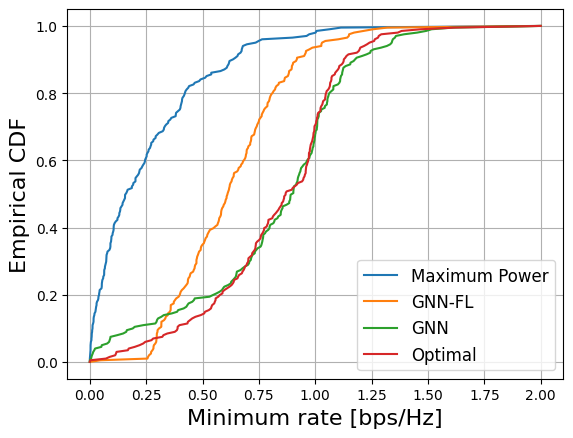

In [23]:
import matplotlib.pyplot as plt
plt.plot(all_one_rates, y_axis, label = 'Maximum Power')
plt.plot(fl_rates, y_axis, label = 'GNN-FL')
plt.plot(gnn_rates, y_axis, label = 'GNN')
plt.plot(opt_rates, y_axis, label = 'Optimal')
plt.xlabel('Minimum rate [bps/Hz]', {'fontsize':16})
plt.ylabel('Empirical CDF', {'fontsize':16})
plt.legend(fontsize = 12)
plt.grid()